# **Sunspots**

One interesting aspect of the Sun is its sunspots. Sunspots are areas where the magnetic field is about 2,500 times stronger than Earth's, much higher than anywhere else on the Sun. Because of the strong magnetic field, the magnetic pressure increases while the surrounding atmospheric pressure decreases. This in turn lowers the temperature relative to its surroundings because the concentrated magnetic field inhibits the flow of hot, new gas from the Sun's interior to the surface.

Sunspots tend to occur in pairs that have magnetic fields pointing in opposite directions. A typical spot consists of a dark region called the umbra, surrounded by a lighter region known as the penumbra. The sunspots appear relatively dark because the surrounding surface of the Sun (the photosphere) is about 10,000 degrees F., while the umbra is about 6,300 degrees F. Sunspots are quite large as an average size is about the same size as the Earth.

Sunspots increase and decrease, then again increases and decreases through an average cycle of 11 years. Solar cycle 1 was the first solar cycle since extensive recording of solar sunspot activity began in 1755 and we have experienced a total of 24 full solar cycles since then. Currently, we are in 25th solar cycle, the solar cycle 25 began in December 2019 and is expected to last till more 11 years that is about 2030.

In [ ]:
#import necessary libraries

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Data handling and Linear algebra
import pandas as pd
import numpy as np

#Manipulating data and Model building
import tensorflow as tf

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

**Diving into the dataset**

In [ ]:
#Importing the data
data = pd.read_csv('/content/Sunspots.csv')
data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
data.tail()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8
3264,3264,2021-01-31,10.4


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.6+ KB


In [ ]:
#Last column--> Sunspots data
sunspots = data.iloc[:,-1]
sunspots.values

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

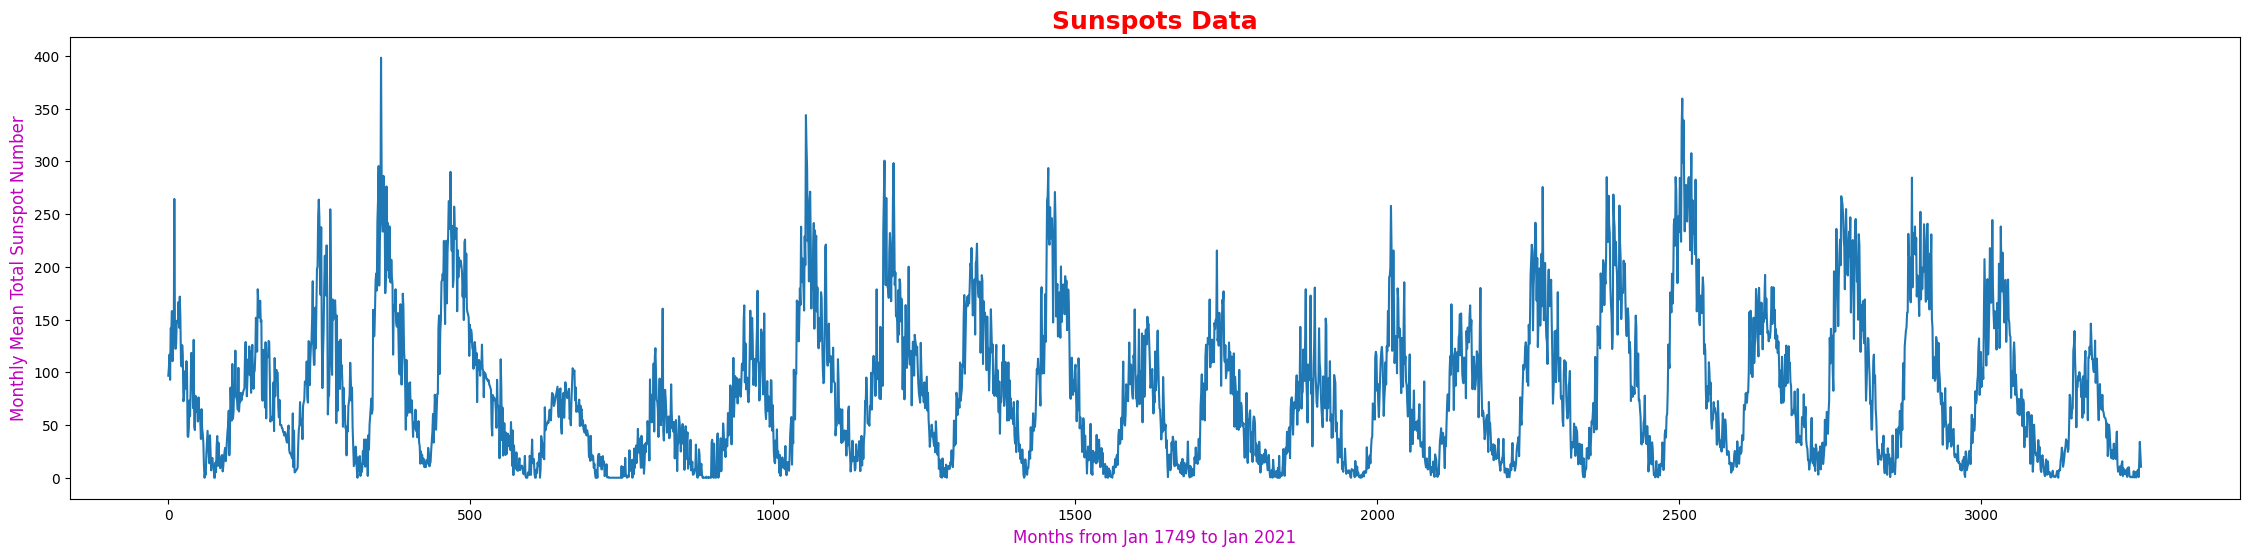

In [ ]:
#Visualize the data
plt.figure(figsize=(28,6))
plt.plot(sunspots)
plt.ylabel(data.columns[-1],fontsize=12,color='m')
plt.xlabel("Months from Jan 1749 to Jan 2021",fontsize=12,color='m')
plt.title("Sunspots Data",fontsize=18,color='r',weight='bold')
plt.show()



*   The first solar cycle started from 1755 but our sunspots data starts from 1749. That's a total of 6 years which means 72 months of data
*   Hence, we can see the initial part of the graph decreasing to minimum till the first 72 months
*   Each solar cycle lasts approx 11 years, that is about 132 months
*   The current cycle is the solar cycle 25 which began in December 2019 but our data is till January 2021. That's about 13 months of data from the current cycle






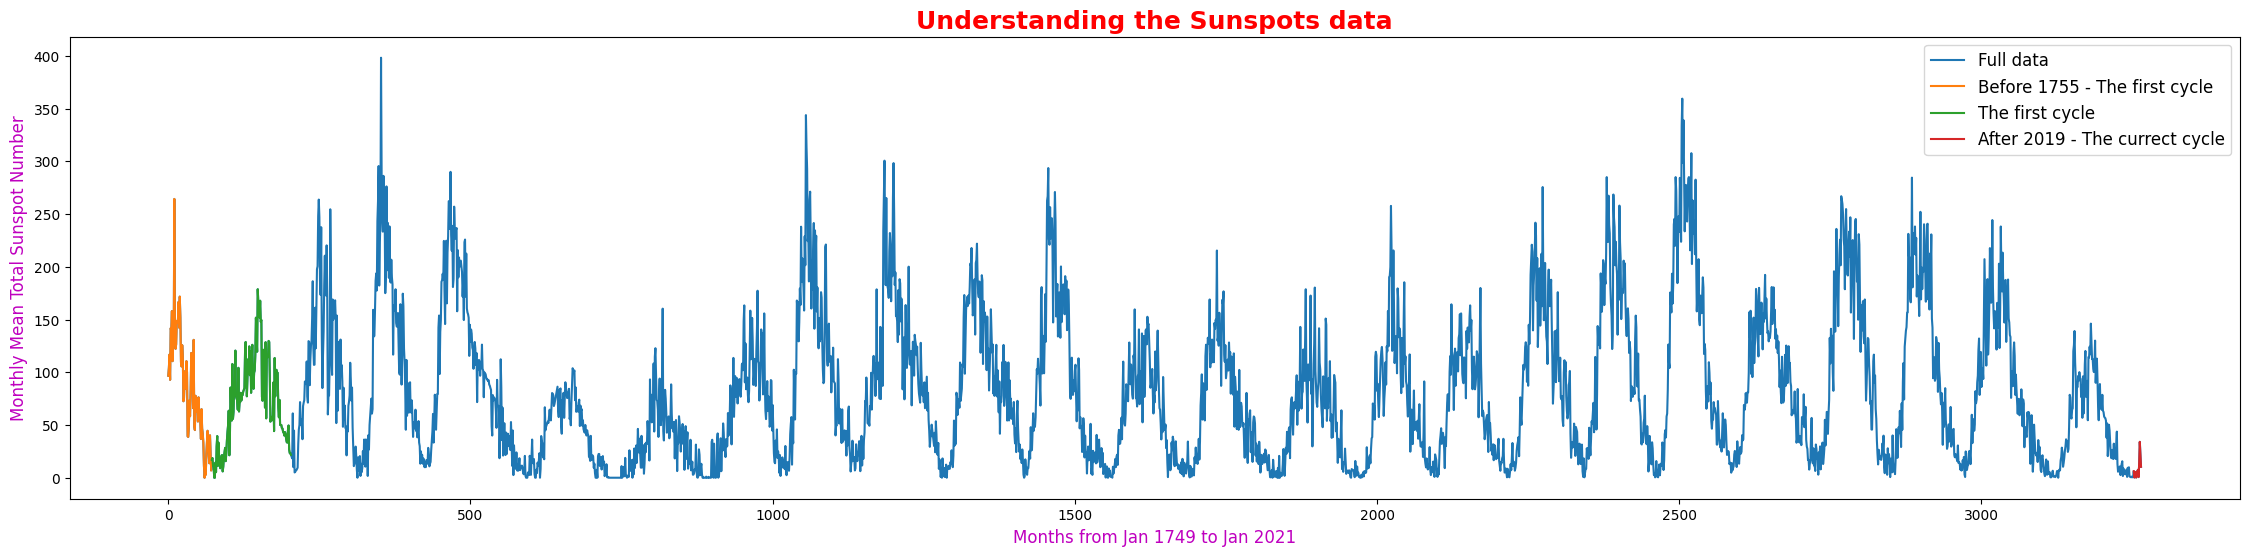

In [ ]:
'''Approx 11 years cycle ---> approx 132 months cycle'''
plt.figure(figsize=(28,6))
plt.plot(sunspots)            # The whole data
plt.plot(sunspots[:72])       # Data from 1749, actual cycles started from 1755 --> 6 years means 72 months
plt.plot(sunspots[72:72+132]) # Showing the first cycle
plt.plot(sunspots[-13:])      # Displaying the current cycle
plt.ylabel(data.columns[-1], fontsize = 12, color = 'm')
plt.xlabel("Months from Jan 1749 to Jan 2021", fontsize = 12, color = 'm')
plt.title("Understanding the Sunspots data", fontsize = 18, color = 'r', weight = 'bold')
plt.legend(["Full data", "Before 1755 - The first cycle", "The first cycle", "After 2019 - The currect cycle"], fontsize = 12)
plt.show()

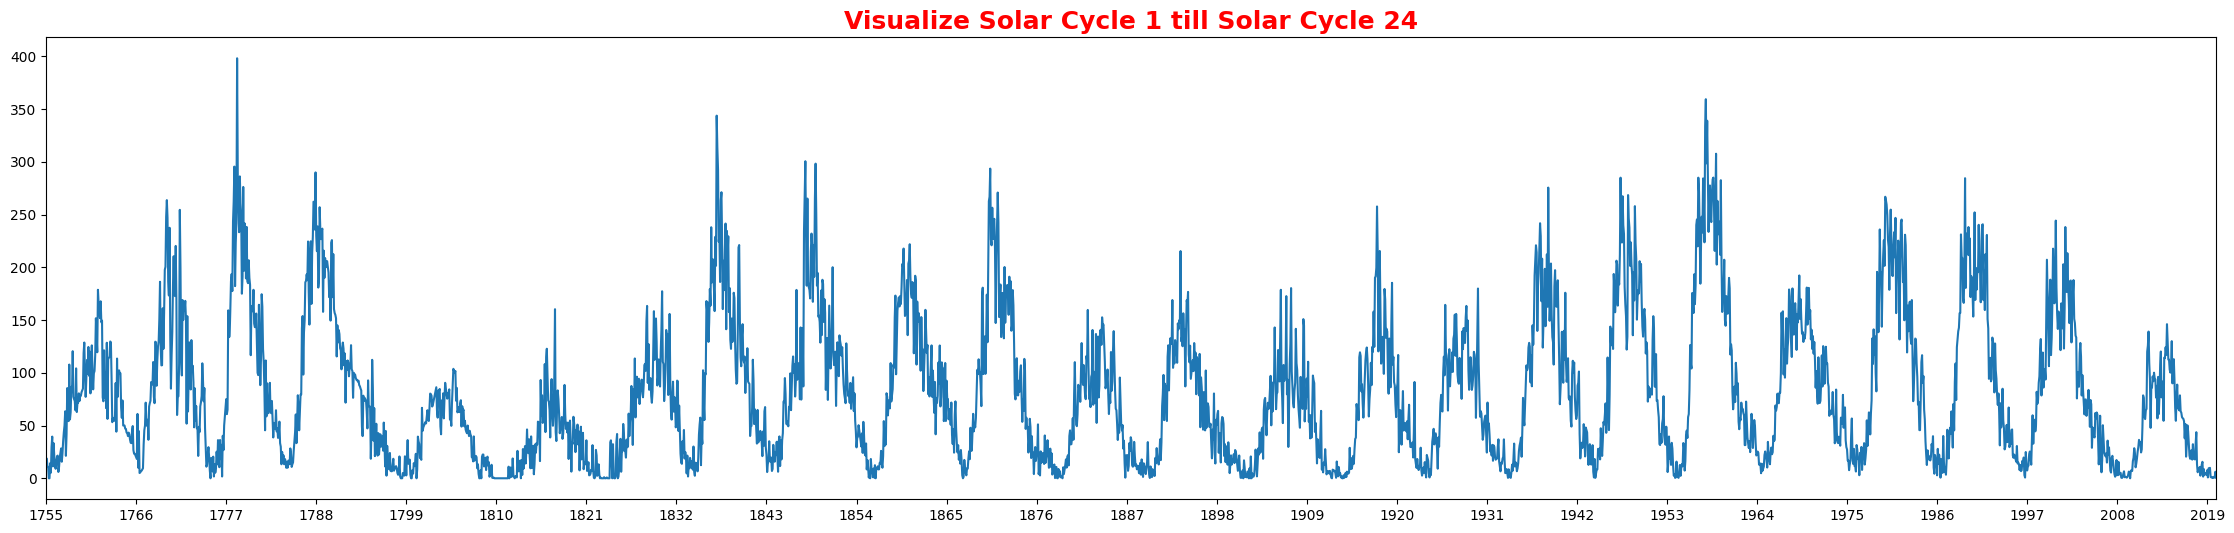

In [ ]:
# Some changes for a better visualization of solar cycles
'''Collect all the years from 1755 to 2019 and use it as xticklabels'''
years = []
start = 1755
for i in range(0, len(data.iloc[:,-1][72:]),132):
    years.append(start)
    start+=11

plt.figure(figsize = (28, 6))
plt.plot(sunspots[72:])
plt.title("Visualize Solar Cycle 1 till Solar Cycle 24", weight = 'bold', color = 'r', fontsize = 18)
plt.xlim(72, 3265-12)
plt.xticks(range(72, len(sunspots),132))
plt.gca().set_xticklabels(years)
plt.show()

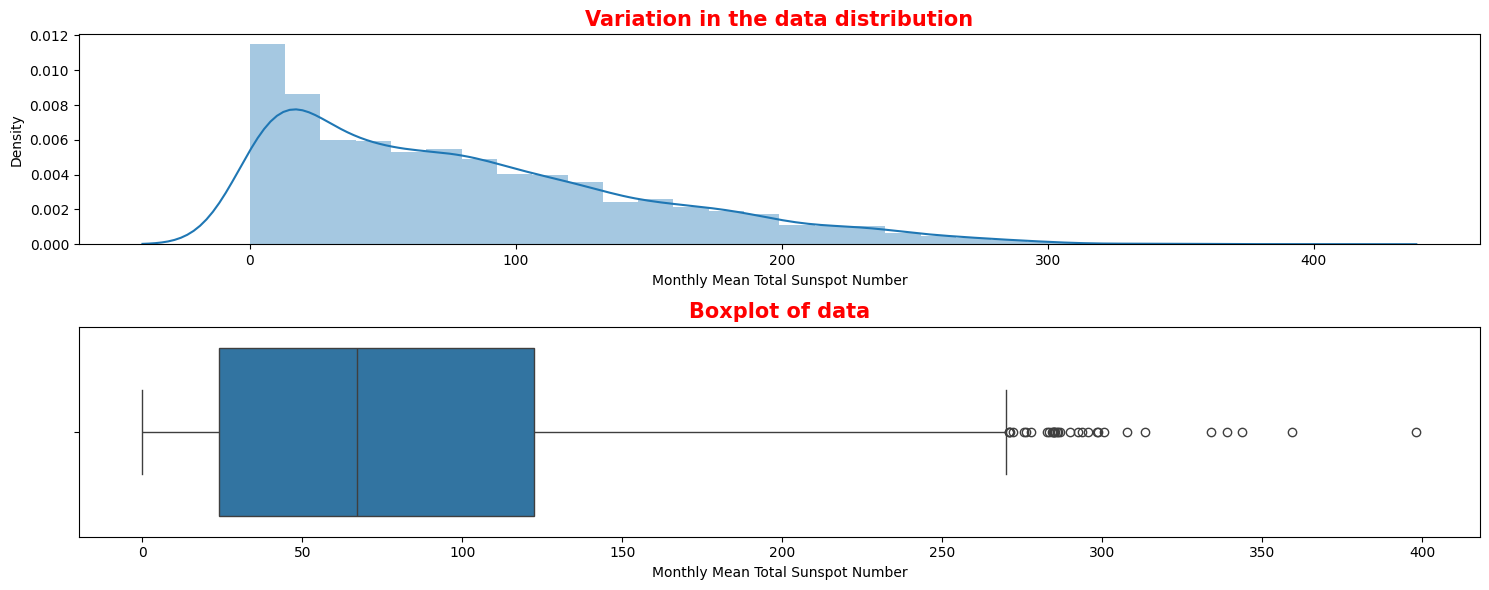

In [ ]:
#Visualize the variation in the data distribution along with the outliers in the time series data
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
sns.distplot(sunspots)
plt.title("Variation in the data distribution",fontsize=15,color='r',weight='bold')
plt.subplot(2,1,2)
sns.boxplot(x=sunspots)
plt.title("Boxplot of data",fontsize=15,color='r',weight='bold')
plt.tight_layout()
plt.show()

**Preparing functions for generating sequences of data and forecasting**

In [ ]:
#Helper function: Training data generation
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[:, np.newaxis]                                # Adding new dimension to the series array in the position where np.newaxis is written
    ds = tf.data.Dataset.from_tensor_slices(series)               # In order to use window of tensorflow convert numpy array to tensor
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # Creating window for generating sequence (yet not seperating it with the future values) - LSTM
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))          # Flatten a dataset of batches into a dataset of their elements
    ds = ds.shuffle(shuffle_buffer)                               # To reduce the variance and making sure that the model remain general and less overfits
    ds = ds.map(lambda w: (w[:-1], w[-1]))                        # In a window, last value is the future value that our model needs to learn and predict while testing it
    return ds.batch(batch_size).prefetch(1)                       # Prefetch one batch of data and make sure that there is always one ready


In [ ]:
# Forecast would work in the same way where we provide the sequence and the output will be predicted by the model
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)  # To predict
    return forecast

**Train-Test Split**

In [ ]:
# Preparing the data
series = data['Monthly Mean Total Sunspot Number'].values
time = data['Unnamed: 0'].values

# Splitting the data into train and test
split_time = int(len(series)*0.9)          # 90% of the original data is for training
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print(f"There are {len(x_train)} training samples and {len(x_valid)} validation samples.")

# Parameters
delta = 1                      # Huber loss
window_size = 60               # For dataset
batch_size = 145               # For dataset
shuffle_buffer_size= 900       # Shuffling the dataset randomly
epochs = 100                   # For optimal learning rate
train_epochs = epochs + 100    # Training epochs
momentum_sgd = 0.9             # For optimizer

There are 2938 training samples and 327 validation samples.


**Build the model and find the best learning rate to optimise model training**

In [ ]:
# To avoid clutter from old models and layers (in case of re-running the notebook without reset and resestart)
tf.keras.backend.clear_session()

# To produce same sequence of results each time the code runs
tf.random.set_seed(42)
np.random.seed(42)

# Calling the window_dataset function to generate the training data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Building the model
model = tf.keras.models.Sequential([
  # Conv1D layers smoothens out the input time-series so we don't have to add the rolling mean or rolling standard deviation values in the input features
  tf.keras.layers.Conv1D(filters=132, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(256, return_sequences=True), # Return sequence if set to true will return the outputs for each time step as explained above
  tf.keras.layers.LSTM(132, return_sequences=False),# Setting it as False will only output the last time step which will then be feeded into the fully connected layers
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)        # To push the values in the range of the original data after getting passed from different activations
])

# Display this model summary
model.summary()

# Using callbacks - Learning rate scheduler to find the optimal value to be used in the final model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20), verbose = 0) # lr --> starting lr * 10^(0/20), starting lr * 10^(1/20), so on..

# Stochastic Gradient Desect as the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=momentum_sgd)
model.compile(loss=tf.keras.losses.Huber(delta),
              optimizer=optimizer,
              metrics=["mae"])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, None, 132)           │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 256)           │         398,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 132)                 │         205,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 80)                  │          10,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             810 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 615,849 (2.35 MB)

 Trainable params: 615,849 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_set, epochs=epochs, callbacks=[lr_schedule]) # Track the history of training

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 71.3464 - mae: 71.8449 - learning_rate: 1.0000e-08
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 65.7141 - mae: 66.2123 - learning_rate: 1.1220e-08
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 63.9007 - mae: 64.3997 - learning_rate: 1.2589e-08
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 58.9784 - mae: 59.4757 - learning_rate: 1.4125e-08
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 55.7666 - mae: 56.2657 - learning_rate: 1.5849e-08
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 52.4282 - mae: 52.9263 - learning_rate: 1.7783e-08
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 48.9253 - mae: 49.4237 - learning_rate: 1.9953e-08
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 44.9572 - mae: 45.4552 - learning_rate: 2.2387e-08
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 42.6503 - mae: 43.1483 - learning_rate: 2.5119e-08
E

In [ ]:
# Learning rates used above
lrs = 1e-8 * (10**(np.arange(epochs)/20))
lrs

array([1.00000000e-08, 1.12201845e-08, 1.25892541e-08, 1.41253754e-08,
       1.58489319e-08, 1.77827941e-08, 1.99526231e-08, 2.23872114e-08,
       2.51188643e-08, 2.81838293e-08, 3.16227766e-08, 3.54813389e-08,
       3.98107171e-08, 4.46683592e-08, 5.01187234e-08, 5.62341325e-08,
       6.30957344e-08, 7.07945784e-08, 7.94328235e-08, 8.91250938e-08,
       1.00000000e-07, 1.12201845e-07, 1.25892541e-07, 1.41253754e-07,
       1.58489319e-07, 1.77827941e-07, 1.99526231e-07, 2.23872114e-07,
       2.51188643e-07, 2.81838293e-07, 3.16227766e-07, 3.54813389e-07,
       3.98107171e-07, 4.46683592e-07, 5.01187234e-07, 5.62341325e-07,
       6.30957344e-07, 7.07945784e-07, 7.94328235e-07, 8.91250938e-07,
       1.00000000e-06, 1.12201845e-06, 1.25892541e-06, 1.41253754e-06,
       1.58489319e-06, 1.77827941e-06, 1.99526231e-06, 2.23872114e-06,
       2.51188643e-06, 2.81838293e-06, 3.16227766e-06, 3.54813389e-06,
       3.98107171e-06, 4.46683592e-06, 5.01187234e-06, 5.62341325e-06,
      

In [ ]:
# Fetch the optimum learning rate
min_loss = min(history.history['loss'])
idx_min_loss = history.history['loss'].index(min_loss)
opt_lr = lrs[idx_min_loss]
first = str(round(float(str(opt_lr).split('e')[0])))
second = str(opt_lr).split('e')[-1]
final = [first, second]
x = "e".join(final)
x = float(x)
print(f"Optimal Learning Rate was --> {x}.")

Optimal Learning Rate was --> 4e-06.


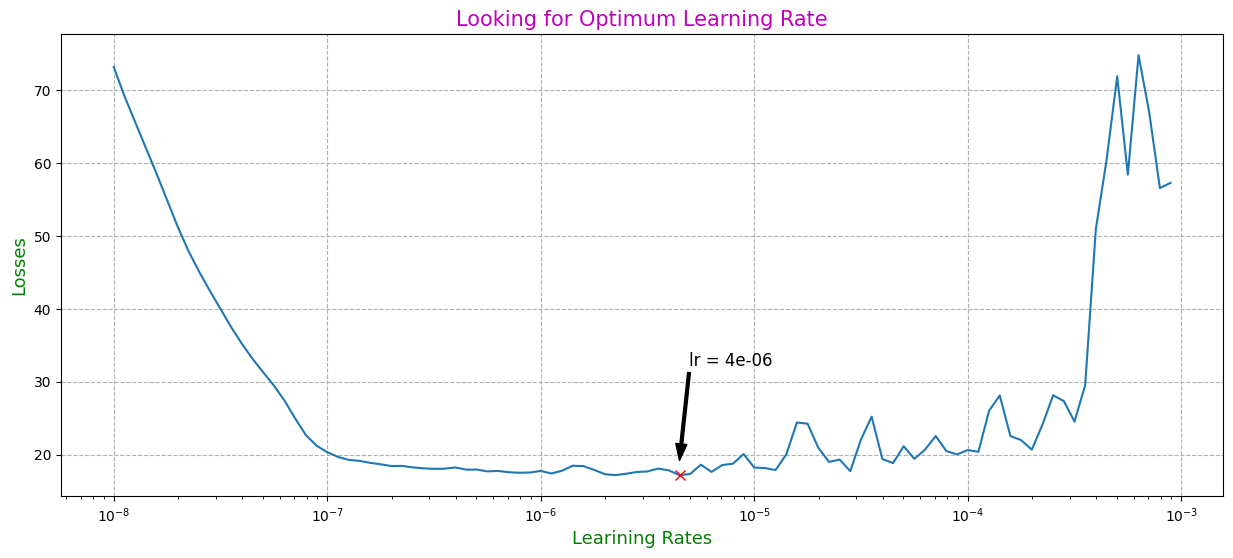

In [ ]:
# Plot the output of Losses vs Learning Rates
fig = plt.figure(figsize=(15, 6))
plt.semilogx(lrs, history.history["loss"]) # Learning rates are increasing exponentially and hence for an omptimal sized plot we use semilogx plot
plt.grid(True, ls="--")
plt.plot(opt_lr,min_loss, color = 'r', marker = 'x', markersize = 7)
plt.title(f"Looking for Optimum Learning Rate", color = 'm', fontsize = 15)
plt.ylabel("Losses", fontsize = 13, color = 'g')
plt.xlabel("Learining Rates", fontsize = 13, color = 'g')
plt.annotate(f"lr = {x}", (opt_lr,min_loss+2), (opt_lr+0.05e-5, min_loss+15), arrowprops = dict(facecolor ='k', width = 2, headwidth = 8), fontsize = 12)
plt.show()

**Training the model with the Optimal Learning Rate**

In [ ]:
# Using the same steps to build the model but now with the optimal learning rate to train it
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=132, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(132, return_sequences=False),
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=opt_lr, momentum=momentum_sgd)
model.compile(loss=tf.keras.losses.Huber(delta),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=train_epochs)

Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 71.1107 - mae: 71.6091
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 34.2815 - mae: 34.7793
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 25.3131 - mae: 25.8084
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 21.1633 - mae: 21.6584
Epoch 5/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 19.7717 - mae: 20.2650
Epoch 6/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 18.8815 - mae: 19.3740
Epoch 7/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 18.5943 - mae: 19.0890
Epoch 8/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 18.4204 - mae: 18.9146
Epoch 9/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 17.9690 - mae: 18.4610
Epoch 10/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 17.6710 - mae: 18.1651
Epoch 11/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 17.5310 - mae: 18.0215
Epoch 12/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 18.1388 - mae: 18.6291
E

**Plots, Results and Predictions**

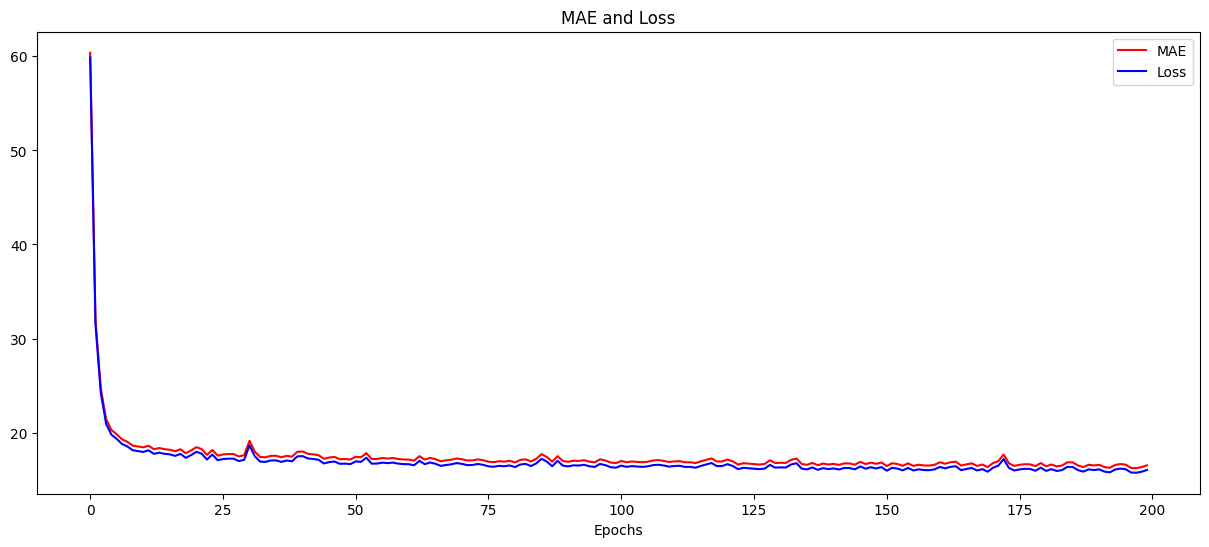

In [ ]:
# Fetch the MAE and Huber Loss from the history
mae=history.history['mae']
loss=history.history['loss']

# Plot MAE and Huber Loss
fig = plt.figure(figsize=(15, 6))
plt.plot(mae, 'r')
plt.plot(loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.legend(["MAE", "Loss"])

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


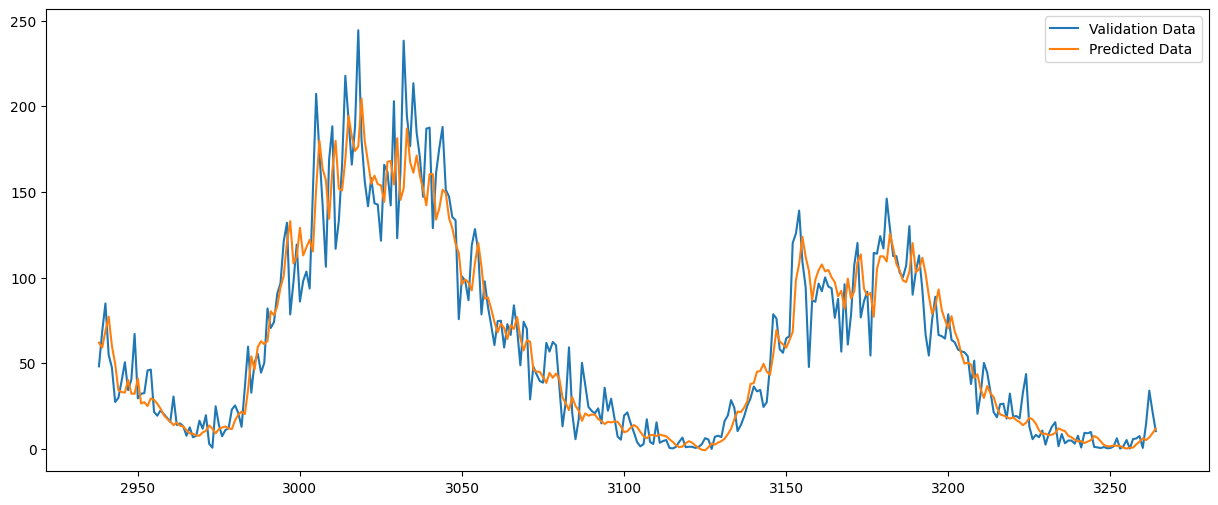

In [ ]:
# Call the model_forecast here and display the plots of validation and prediction
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, 0]  # rnn_forecast[-328:-1, 0]

# Plots
plt.figure(figsize=(15, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)
plt.title("")
plt.legend(["Validation Data", "Predicted Data"])
plt.show()

In [ ]:
# Validation MAE
val_mae=tf.keras.metrics.mae(x_valid, rnn_forecast).numpy()
print(f"MAE on the validation data:- {val_mae}")

MAE on the validation data:- 12.598735809326172
